In [26]:
import torch
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import segmentation
from torchvision.io import decode_image
from torchvision.utils import make_grid
from os import listdir, path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torchvision.transforms.functional as F

from PIL import Image, ImageDraw, ImageFont
import math

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")
dataset_root = "images"
model_path = "part3-model.pth"
model = None

GPU is available


# Part 3 - Segmentation

In [29]:
weights = segmentation.FCN_ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

VOC_PALETTE = np.array([
    [0,   0,   0],  # 0 background
    [128,   0,   0],  # 1 aeroplane
    [0, 128,   0],  # 2 bicycle
    [128, 128,   0],  # 3 bird
    [0,   0, 128],  # 4 boat
    [128,   0, 128],  # 5 bottle
    [0, 128, 128],  # 6 bus
    [128, 128, 128],  # 7 car
    [64,   0,   0],  # 8 cat
    [192,   0,   0],  # 9 chair
    [64, 128,   0],  # 10 cow
    [192, 128,   0],  # 11 dining-table
    [64,   0, 128],  # 12 dog
    [192,   0, 128],  # 13 horse
    [64, 128, 128],  # 14 motorbike
    [192, 128, 128],  # 15 person
    [0,  64,   0],  # 16 potted-plant
    [128,  64,   0],  # 17 sheep
    [0, 192,   0],  # 18 sofa
    [128, 192,   0],  # 19 train
    [0,  64, 128],  # 20 tv/monitor
], dtype=np.uint8)

VOC_LABELS = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car",
    "cat", "chair", "cow", "dining-table", "dog", "horse", "motorbike", "person",
    "potted-plant", "sheep", "sofa", "train", "tv/monitor"
]


def make_model():
    return segmentation.fcn_resnet50(weights=weights).to(device)


def load_dataset():
    images: list[torch.Tensor] = [
        decode_image(path.join(dataset_root, f),
                     mode=torchvision.io.ImageReadMode.RGB)
        for f in listdir(dataset_root)
        if f.endswith(".jpg")
    ]

    return images


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        try:
            img = img.detach()
        except:
            pass
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def simple_voc_legend(
        palette=VOC_PALETTE,
        labels=VOC_LABELS,
        square=28,          # pixel size of the colour chip
        gap=6,              # gap between chips and text
        pad=6,              # outer padding
        cols=4,             # chips per row
        font_size=15
):
    rows = math.ceil(len(labels)/cols)

    # crude attempt to load a default truetype font; falls back to PIL bitmap
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    # rough text width (all labels), for canvas size
    max_text_w = max(font.getlength(lbl) for lbl in labels)
    w = pad*2 + cols*(square + gap + max_text_w)
    h = pad*2 + rows*square

    img = Image.new("RGB", (int(w), int(h)), (255, 255, 255))
    draw = ImageDraw.Draw(img)

    for idx, (rgb, lbl) in enumerate(zip(palette, labels)):
        r, c = divmod(idx, cols)
        x0 = pad + c*(square + gap + max_text_w)
        y0 = pad + r*square
        # coloured square
        draw.rectangle([x0, y0, x0+square, y0+square],
                       fill=tuple(int(v) for v in rgb))
        # text baseline is vertically centred inside the square
        tx = x0 + square + gap
        ty = y0 + (square - font_size)//2
        draw.text((tx, ty), lbl, fill=(0, 0, 0), font=font)

    return F.to_tensor(img)

{'__background__': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}


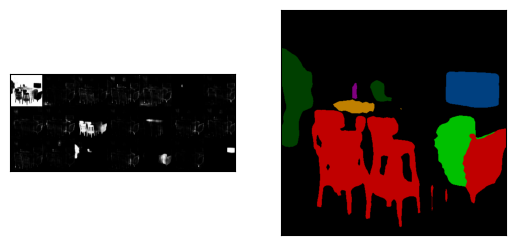

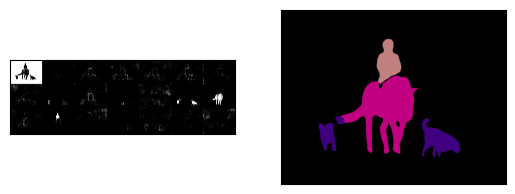

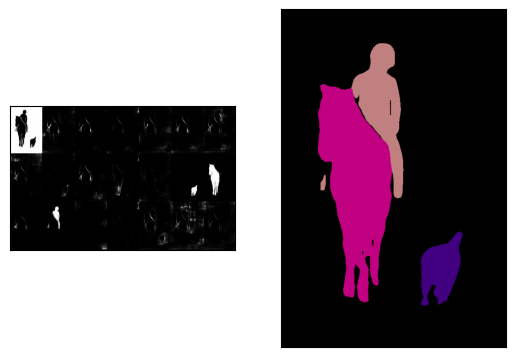

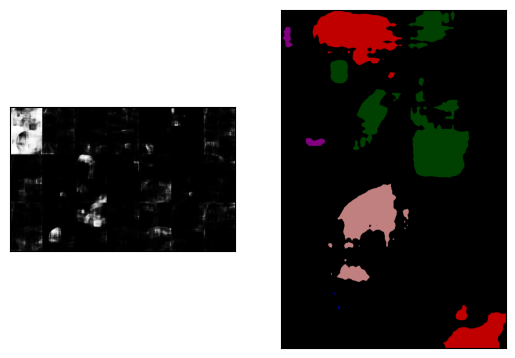

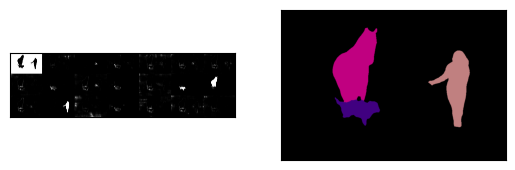

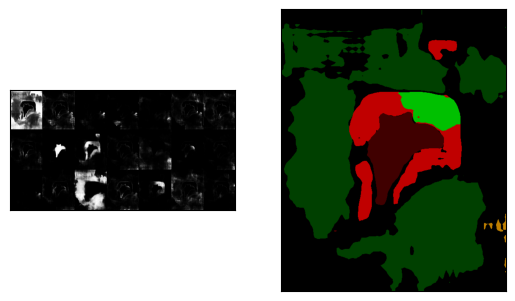

In [ ]:
model = make_model().eval()
dataset = load_dataset()

sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

print(sem_class_to_idx)

for i in dataset:
    pre = preprocess(i).unsqueeze(0).to(device)
    output: torch.Tensor = model(pre)["out"][0]

    normalized_masks = torch.nn.functional.softmax(output, dim=0)

    feature_map = make_grid(normalized_masks.unsqueeze(1),
                  nrow=7, padding=2, normalize=True, scale_each=True)
    
    segmentation = VOC_PALETTE[normalized_masks.cpu().argmax(dim=0)]

    show([feature_map, segmentation])